# LORENZ 96 BILSTM (NO ITERATIVE FUNCTION)

This problem is memory intensive

In [7]:
import numpy as np
# Equation Params
F = 8  # Forcing parameter
N = 25  # Number of variables

np.random.seed(1)
X0 = np.random.randn(N) 

# Time Params
t_end = 100                  # t final (minimum threshold is 100..? model may need some refinement)
t_points = 10000           # points
lyapunov_exponent = 1       # set to 1 to ignore lyapunov

# Split Param
split_ratio = 1/5
validation_split = 1/8

# Scaler Params (don't modify unless you know what you are doing)
feature_range = (0, 1)

# Model Hyperparams (don't need to modify unless want to)
lstm_dim = 384
learning_rate = 0.001
epochs = 100
batch_size = 32

# Params for the iterative forecast 
num_iterations = 1

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from keras.constraints import max_norm
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.initializers import GlorotUniform
from keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Add, TimeDistributed, Input, RepeatVector, Concatenate, Attention
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Define the Lorenz-96 system
def lorenz96(X, t, F):
    N = len(X)
    dXdt = np.zeros(N)
    for i in range(N):
        dXdt[i] = (X[(i + 1) % N] - X[i - 2]) * X[i - 1] - X[i] + F
    return dXdt


# Time span
t = np.linspace(0, t_end, t_points)

lyapunov_time = 1 / np.abs(lyapunov_exponent)
t_lyapunov = t / lyapunov_time

# Solve Lorenz-96 equations using odeint
solution = odeint(lorenz96, X0, t_lyapunov, args=(F,))
solution = solution[:, :N]

# Split data into input and ground truth
points_length = int(len(solution) * split_ratio)
input_solution = solution[:points_length]
ground_truth_solution = solution[points_length:]

# Further split data into training, validation, and test sets
validation_length = int(len(input_solution) * validation_split)
X_train = input_solution[:points_length - validation_length]
X_val = input_solution[points_length - validation_length:points_length]
X_test = ground_truth_solution

time_train = t[:points_length - validation_length]
time_val = t[points_length - validation_length:points_length]
time_test = t[points_length:]

# Scale input data
scaler = MinMaxScaler(feature_range=feature_range)
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

# Reshape input data for LSTM
X_train_normalized = X_train_normalized.reshape(-1, 1, N)
X_val_normalized = X_val_normalized.reshape(-1, 1, N)
X_test_normalized = X_test_normalized.reshape(-1, 1, N)

# Define LSTM model
model = Sequential([
    Bidirectional(LSTM(lstm_dim, input_shape=(X_train_normalized.shape[1], X_train_normalized.shape[2]), return_sequences=True, activation='sigmoid', kernel_constraint=max_norm(0.99))),
    BatchNormalization(),
    Dense(N),
    Dense(N),
    BatchNormalization(),
])

# Compile the model
optimizer = Adam(learning_rate=0.01, clipnorm=0.99)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(X_train_normalized, X_train_normalized, epochs=epochs, batch_size=batch_size,
                    verbose=1, validation_data=(X_val_normalized, X_val_normalized)
                    )

# Predict using the trained model
predicted_solution_normalized = model.predict(X_test_normalized)

# Inverse transform predicted solution to original scale
predicted_solution = scaler.inverse_transform(predicted_solution_normalized.reshape(-1, N))

# Calculate absolute error between ground truth and predicted solution
error = np.abs(ground_truth_solution - predicted_solution)

# mse = mean_squared_error(ground_truth_solution, predicted_solution)
# print("Mean Squared Error (MSE) on test set:", mse)

Epoch 1/100


c:\Users\farxa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.7089 - val_loss: 0.0472
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0717 - val_loss: 0.0380
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0060 - val_loss: 0.0385
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0027 - val_loss: 0.0367
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0024 - val_loss: 0.0346
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0021 - val_loss: 0.0316
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0020 - val_loss: 0.0271
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0022 - val_loss: 0.0227
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0019 - val_loss: 0.0174
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0020 - val_loss: 0.0132
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0020 - val_loss: 0.0079
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.

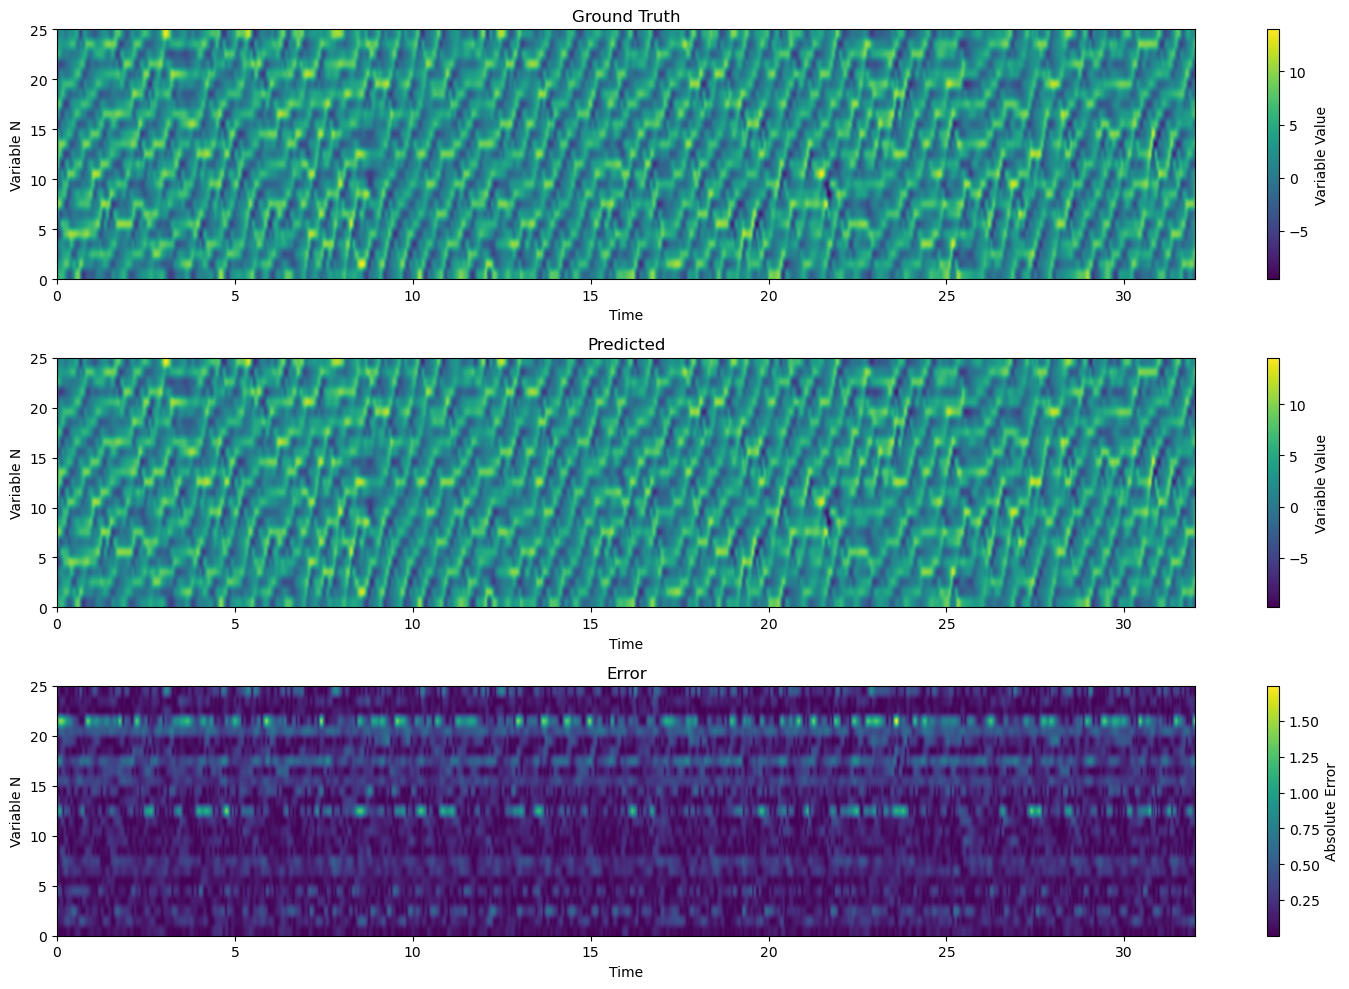

In [9]:
# Plot Ground Truth Atmospheric Graph
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.imshow(ground_truth_solution[:len(ground_truth_solution)].T, aspect='auto', cmap='viridis', extent=[0, t[-1] * 3.2/10, 0, N])
plt.colorbar(label='Variable Value')
plt.xlabel('Time')
plt.ylabel('Variable N')
plt.title('Ground Truth')

# Plot Predicted Atmospheric Graph
plt.subplot(3, 1, 2)
plt.imshow(predicted_solution[:len(ground_truth_solution)].T, aspect='auto', cmap='viridis', extent=[0, t[-1] * 3.2/10, 0, N])
plt.colorbar(label='Variable Value')
plt.xlabel('Time')
plt.ylabel('Variable N')
plt.title('Predicted')

# Plot Error Atmospheric Graph
plt.subplot(3, 1, 3)
plt.imshow(error[:len(ground_truth_solution)].T, aspect='auto', cmap='viridis', extent=[0, t[-1] * 3.2/10, 0, N])
plt.colorbar(label='Absolute Error')
plt.xlabel('Time')
plt.ylabel('Variable N')
plt.title('Error')

plt.tight_layout()
plt.show()
